In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from pathlib import Path
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

import warnings
warnings.filterwarnings("ignore")

![](https://i.ibb.co/5TfQCc0/nfl.png)

# Table of Contents

* [upload the data](#one)
* [Exploratory Data Analysis of defence team composition](#two)
* [Most popular offence formations and team composition](#three)
* [Dropbacks and penalties](#four)
* [Detailed play analysis](#five)

    * [Plotting a play](#six)
    * [Defence pass interference](#seven)
    * [Data preparation](#eight)
    * [Model creation](#nine)
    * [model score](#ten)
    * [conclusion](#eleven)

<a id="one"></a>
# upload the data

In [2]:
path = Path('/kaggle/input/nfl-big-data-bowl-2021')
df_games = pd.read_csv(path/'games.csv')
df_players = pd.read_csv(path/'players.csv')
df_plays = pd.read_csv(path/'plays.csv')
df_week1 = pd.read_csv(path/'week1.csv')

That's a lot of dataframes . i'll skip standard NaN\null , values check ,implying anyone who is looking this notebook is familiar with data.

First of all, i want to make new dataframe with high score\low score brackets to get the idea about team composition

In [3]:
df_games.visitorTeamAbbr.sort_values().unique() == df_games.homeTeamAbbr.sort_values().unique()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [4]:
team_names = df_games.visitorTeamAbbr.sort_values().unique()
df_teams = pd.DataFrame(team_names,columns=['team'])

In [5]:
df_teams['wins'] = 0
df_teams['score'] = 0

In [6]:
#creating columns for the offence formation
df_teams['I_FORM'] = 0
df_teams['SINGLEBACK'] = 0
df_teams['SHOTGUN'] = 0
df_teams['EMPTY'] = 0
df_teams['PISTOL'] = 0
df_teams['WILDCAT'] = 0
df_teams['JUMBO'] = 0

In [7]:
for index,game in df_games.iterrows():
    home_team = game.homeTeamAbbr
    visitor_team = game.visitorTeamAbbr
    home_team_index = df_teams[df_teams.team == home_team].index
    visitor_team_index = df_teams[df_teams.team == visitor_team].index
    #total score and index
    home_score = df_plays[df_plays.gameId == game.gameId].preSnapHomeScore.max()
    visitor_score = df_plays[df_plays.gameId == game.gameId].preSnapVisitorScore.max()
    if home_score > visitor_score:
        total_wins = df_teams[df_teams.team == home_team].wins.values
        df_teams['wins'][home_team_index] = total_wins + 1
    elif visitor_score > home_score:
        total_wins = df_teams[df_teams.team == visitor_team].wins.values
        df_teams['wins'][visitor_team_index] = total_wins + 1
    else:
        pass
    total_home_score = df_teams[df_teams.team == home_team].score.values
    total_visiter_score = df_teams[df_teams.team == visitor_team].score.values
    df_teams['score'][home_team_index] = total_home_score + home_score
    df_teams['score'][visitor_team_index] = total_visiter_score + visitor_score
    #offence
    ht_offence = df_plays[(df_plays.gameId == game.gameId) & (df_plays.possessionTeam == home_team)].offenseFormation.value_counts()
    vt_offence = df_plays[(df_plays.gameId == game.gameId) & (df_plays.possessionTeam == visitor_team)].offenseFormation.value_counts()
    ht_offence_dict = ht_offence.to_dict()
    for k,v in ht_offence_dict.items():
        total_of = df_teams[df_teams.team == home_team][k].values
        df_teams[k][home_team_index] = total_of + v
    vt_offence_dict = vt_offence.to_dict()
    for k,v in vt_offence_dict.items():
        total_of = df_teams[df_teams.team == visitor_team][k].values
        df_teams[k][visitor_team_index] = total_of + v

In [8]:
df_teams.sort_values(by='score', ascending=False)

,team,wins,score,I_FORM,SINGLEBACK,SHOTGUN,EMPTY,PISTOL,WILDCAT,JUMBO
16,LA,12,524.0,4,218,271,113,6,0,0
15,KC,12,524.0,9,49,448,77,11,0,0
21,NO,12,483.0,34,109,297,99,4,6,4
20,NE,11,433.0,61,107,343,96,3,1,1
26,PIT,9,421.0,9,45,484,189,3,0,3
5,CHI,12,421.0,14,30,419,71,7,1,1
13,IND,9,416.0,9,74,503,87,5,1,3
1,ATL,6,392.0,63,153,339,108,3,0,0
12,HOU,10,389.0,8,80,345,125,4,20,0
17,LAC,11,389.0,31,93,300,78,3,0,1


with that data you can have a basic understanding what to expect from team.
 And i want to go deeper into Exploratory Data Analysis of defence team composition

<a id="two"></a>
# Exploratory Data Analysis of defence team composition

In [9]:
df_offence_persd = df_plays.groupby('offenseFormation')['personnelD'].value_counts()
df_offence_defbox = df_plays.groupby('offenseFormation')['defendersInTheBox'].value_counts()

**defence against EMPTY fromation**

In [10]:
df_offence_persd['EMPTY'].head(7),df_offence_defbox['EMPTY'].sort_values(ascending=False).head(4)

(personnelD
 4 DL, 2 LB, 5 DB    939
 3 DL, 3 LB, 5 DB    368
 2 DL, 4 LB, 5 DB    257
 4 DL, 3 LB, 4 DB    223
 4 DL, 1 LB, 6 DB    154
 3 DL, 2 LB, 6 DB    142
 2 DL, 3 LB, 6 DB    132
 Name: personnelD, dtype: int64,
 defendersInTheBox
 5.0    1014
 6.0     867
 4.0     374
 7.0     140
 Name: defendersInTheBox, dtype: int64)

if you facing offence formation and happend to have no idea what defence pattern is more preferable.
Use this data to begin with. Also helps to get the idea what defence pattern you could be facing otherwise

**defence against I_FORM formation**

In [11]:
df_offence_persd['I_FORM'].head(6),df_offence_defbox['I_FORM'].sort_values(ascending=False).head(5)

(personnelD
 4 DL, 3 LB, 4 DB    514
 3 DL, 4 LB, 4 DB    150
 4 DL, 2 LB, 5 DB    119
 3 DL, 3 LB, 5 DB     51
 2 DL, 4 LB, 5 DB     30
 5 DL, 2 LB, 4 DB     28
 Name: personnelD, dtype: int64,
 defendersInTheBox
 7.0    467
 8.0    275
 6.0    135
 9.0     24
 5.0     12
 Name: defendersInTheBox, dtype: int64)

**defence against SINGLEBACK formation**

In [12]:
df_offence_persd['SINGLEBACK'].head(5),df_offence_defbox['SINGLEBACK'].sort_values(ascending=False).head(5)

(personnelD
 4 DL, 2 LB, 5 DB    891
 4 DL, 3 LB, 4 DB    869
 3 DL, 3 LB, 5 DB    346
 2 DL, 4 LB, 5 DB    285
 3 DL, 4 LB, 4 DB    260
 Name: personnelD, dtype: int64,
 defendersInTheBox
 7.0    1319
 6.0     865
 8.0     501
 5.0      61
 9.0      36
 Name: defendersInTheBox, dtype: int64)

**defence against SHOTGUN formation**

In [13]:
df_offence_persd['SHOTGUN'].head(7),df_offence_defbox['SHOTGUN'].sort_values(ascending=False).head(5)

(personnelD
 4 DL, 2 LB, 5 DB    4571
 3 DL, 3 LB, 5 DB    2289
 2 DL, 4 LB, 5 DB    1508
 3 DL, 2 LB, 6 DB     870
 4 DL, 1 LB, 6 DB     867
 4 DL, 3 LB, 4 DB     724
 2 DL, 3 LB, 6 DB     719
 Name: personnelD, dtype: int64,
 defendersInTheBox
 6.0    6809
 7.0    2364
 5.0    2314
 4.0     767
 8.0     243
 Name: defendersInTheBox, dtype: int64)

**defence against PISTOL formation**

In [14]:
df_offence_persd['PISTOL'].head(7),df_offence_defbox['PISTOL'].sort_values(ascending=False).head(4)

(personnelD
 4 DL, 2 LB, 5 DB    85
 4 DL, 3 LB, 4 DB    61
 3 DL, 3 LB, 5 DB    33
 4 DL, 1 LB, 6 DB    23
 2 DL, 4 LB, 5 DB    19
 3 DL, 4 LB, 4 DB    14
 3 DL, 2 LB, 6 DB     8
 Name: personnelD, dtype: int64,
 defendersInTheBox
 6.0    102
 7.0     93
 8.0     27
 5.0     23
 Name: defendersInTheBox, dtype: int64)

**defence against WILDCAT formation**

In [15]:
df_offence_persd['WILDCAT'].head(4),df_offence_defbox['WILDCAT'].sort_values(ascending=False).head(3)

(personnelD
 4 DL, 2 LB, 5 DB    16
 4 DL, 1 LB, 6 DB     7
 4 DL, 3 LB, 4 DB     6
 2 DL, 4 LB, 5 DB     3
 Name: personnelD, dtype: int64,
 defendersInTheBox
 6.0    17
 7.0     9
 5.0     9
 Name: defendersInTheBox, dtype: int64)

**defence against JUMBO formation**

In [16]:
df_offence_persd['JUMBO'].head(8),df_offence_defbox['JUMBO'].sort_values(ascending=False).head(4)

(personnelD
 5 DL, 3 LB, 3 DB          9
 6 DL, 4 LB, 1 DB          9
 6 DL, 3 LB, 2 DB          8
 4 DL, 4 LB, 3 DB          7
 4 DL, 3 LB, 4 DB          5
 4 DL, 5 LB, 2 DB          4
 6 DL, 2 LB, 3 DB          3
 5 DL, 3 LB, 2 DB, 1 OL    2
 Name: personnelD, dtype: int64,
 defendersInTheBox
 10.0    24
 11.0    14
 9.0      6
 8.0      6
 Name: defendersInTheBox, dtype: int64)

<a id="three"></a>
# Most popular offence formations and team composition

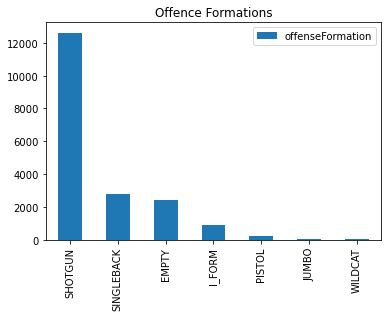

In [17]:
df_formation_counts = df_plays.offenseFormation.value_counts().to_frame()
df_formation_counts.plot(kind='bar',title='Offence Formations')

In [18]:
df_offence_perso = df_plays.groupby('offenseFormation')['personnelO'].value_counts()
df_offence_rushers = df_plays.groupby('offenseFormation')['numberOfPassRushers'].value_counts()

**recommended team composition with I_FORM formation**

In [19]:
df_offence_perso['I_FORM'].head(7),df_offence_rushers['I_FORM'].sort_values(ascending=False).head(6)

(personnelO
 2 RB, 1 TE, 2 WR          450
 1 RB, 2 TE, 2 WR          166
 2 RB, 2 TE, 1 WR           91
 1 RB, 1 TE, 3 WR           86
 1 RB, 3 TE, 1 WR           51
 2 RB, 0 TE, 3 WR           26
 6 OL, 2 RB, 1 TE, 1 WR     10
 Name: personnelO, dtype: int64,
 numberOfPassRushers
 4.0    478
 5.0    235
 6.0     83
 3.0     54
 7.0     21
 2.0     11
 Name: numberOfPassRushers, dtype: int64)

**recommended team composition with SINGLEBACK formation**

In [20]:
df_offence_perso['SINGLEBACK'].head(5),df_offence_rushers['SINGLEBACK'].sort_values(ascending=False).head(5)

(personnelO
 1 RB, 1 TE, 3 WR          1267
 1 RB, 2 TE, 2 WR          1046
 1 RB, 3 TE, 1 WR           183
 6 OL, 1 RB, 1 TE, 2 WR      86
 2 RB, 1 TE, 2 WR            81
 Name: personnelO, dtype: int64,
 numberOfPassRushers
 4.0    1470
 5.0     612
 6.0     245
 3.0     234
 7.0      77
 Name: numberOfPassRushers, dtype: int64)

**recommended team composition with SHOTGUN formation**

In [21]:
df_offence_perso['SHOTGUN'].head(5),df_offence_rushers['SHOTGUN'].sort_values(ascending=False).head(6)

(personnelO
 1 RB, 1 TE, 3 WR    10505
 1 RB, 2 TE, 2 WR     1148
 2 RB, 1 TE, 2 WR      411
 1 RB, 0 TE, 4 WR      214
 2 RB, 0 TE, 3 WR      100
 Name: personnelO, dtype: int64,
 numberOfPassRushers
 4.0    7904
 5.0    2312
 3.0     935
 6.0     723
 2.0     169
 7.0     118
 Name: numberOfPassRushers, dtype: int64)

**recommended team composition with EMPTY formation**

In [22]:
df_offence_perso['EMPTY'].head(6),df_offence_rushers['EMPTY'].sort_values(ascending=False).head(5)

(personnelO
 1 RB, 1 TE, 3 WR    1652
 1 RB, 2 TE, 2 WR     291
 0 RB, 1 TE, 4 WR     142
 2 RB, 1 TE, 2 WR     122
 1 RB, 3 TE, 1 WR      66
 1 RB, 0 TE, 4 WR      53
 Name: personnelO, dtype: int64,
 numberOfPassRushers
 4.0    1509
 5.0     419
 3.0     341
 6.0      54
 2.0      17
 Name: numberOfPassRushers, dtype: int64)

**recommended team composition with PISTOL formation**

In [23]:
df_offence_perso['PISTOL'].head(4),df_offence_rushers['PISTOL'].sort_values(ascending=False).head(4)

(personnelO
 1 RB, 1 TE, 3 WR    124
 1 RB, 2 TE, 2 WR     76
 2 RB, 1 TE, 2 WR     19
 1 RB, 3 TE, 1 WR     13
 Name: personnelO, dtype: int64,
 numberOfPassRushers
 4.0    134
 5.0     53
 3.0     25
 6.0     15
 Name: numberOfPassRushers, dtype: int64)

**recommended team composition with WILDCAT formation**

In [24]:
df_offence_perso['WILDCAT'],df_offence_rushers['WILDCAT'].sort_values(ascending=False).head(3)

(personnelO
 2 QB, 1 RB, 1 TE, 2 WR    28
 2 QB, 1 RB, 2 TE, 1 WR     3
 1 RB, 2 TE, 2 WR           2
 2 QB, 0 RB, 1 TE, 3 WR     2
 1 RB, 1 TE, 3 WR           1
 Name: personnelO, dtype: int64,
 numberOfPassRushers
 4.0    21
 3.0     6
 5.0     4
 Name: numberOfPassRushers, dtype: int64)

**recommended team composition with JUMBO formation**

In [25]:
df_offence_perso['JUMBO'].head(7),df_offence_rushers['JUMBO'].sort_values(ascending=False).head(4)

(personnelO
 6 OL, 2 RB, 2 TE, 0 WR         18
 6 OL, 1 RB, 3 TE, 0 WR          8
 2 RB, 3 TE, 0 WR                7
 1 RB, 4 TE, 0 WR                5
 1 RB, 3 TE, 1 WR                4
 6 OL, 1 RB, 2 TE, 0 WR,1 DL     4
 6 OL, 2 RB, 1 TE, 0 WR,1 DL     3
 Name: personnelO, dtype: int64,
 numberOfPassRushers
 6.0    15
 7.0    13
 5.0     8
 8.0     7
 Name: numberOfPassRushers, dtype: int64)

We have a data about dropbacks, it's literally asking to be plotted

<a id="four"></a>
# Dropbacks and penalties

In [26]:
    df_dropback = df_plays.typeDropback.value_counts().reset_index()

Text(0.5, 1.0, 'dropback type')

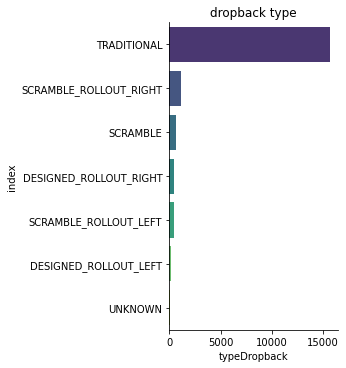

In [27]:
sns.catplot(data=df_dropback,x='typeDropback',y='index',kind='bar',palette="viridis")
plt.title('dropback type')

Text(0.5, 1.0, 'top penalties')

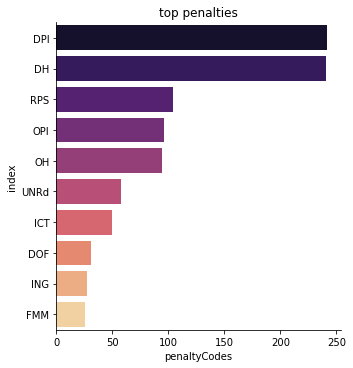

In [28]:
df_penalties = df_plays.penaltyCodes.value_counts().head(10).reset_index()
sns.catplot(data=df_penalties,x='penaltyCodes',y='index',kind='bar',palette="magma")
plt.title('top penalties')

<a id="five"></a>
# DETAILED PLAY ANALYSIS

<a id="six"></a>
# Plotting a play
lets finally take a look at play

In [29]:
def get_teams(players):
    away_team = []
    home_team = []
    for k,v in players.index:
        if k == 'away':
            away_team.append(v)
        elif k == 'home':
            home_team.append(v)
        else:
            pass
    return away_team,home_team

In [30]:
def plot_play(gameid,playid,df_week):
    players = df_week[(df_week.playId == playid) & (df_week.gameId == gameid)].groupby('team')['nflId'].value_counts()
    away_team,home_team = get_teams(players)
    plt.figure(figsize=(12,6))
    plt.xlim(0,120)
    plt.ylim(0,53.3)
    for at in away_team:
        df = pd.DataFrame(df_week[(df_week.playId == playid) & (df_week.gameId == gameid) & (df_week.nflId == at)]['x'])
        df['y'] = df_week[(df_week.playId == playid) & (df_week.gameId == gameid) & (df_week.nflId == at)]['y']
        df.reset_index()
        plt.scatter(df.iloc[0]['x'],df.iloc[0]['y'],c='r')
        plt.plot('x','y',data=df,c='r')
    for ht in home_team:
        df = pd.DataFrame(df_week[(df_week.playId == playid) & (df_week.gameId == gameid) & (df_week.nflId == ht)]['x'])
        df['y'] = df_week[(df_week.playId == playid) & (df_week.gameId == gameid) & (df_week.nflId == ht)]['y']
        df.reset_index()
        plt.scatter(df.iloc[0]['x'],df.iloc[0]['y'],c='b')
        plt.plot('x','y',data=df,c='b')
    dfball = pd.DataFrame(df_week[(df_week.playId == playid) & (df_week.gameId == gameid) & (df_week.displayName == 'Football')]['x'])
    dfball['y'] = df_week[(df_week.playId == playid) & (df_week.gameId == gameid) & (df_week.displayName == 'Football')]['y']
    dfball.reset_index()
    plt.scatter(dfball.iloc[0]['x'],dfball.iloc[0]['y'],c='g')
    plt.plot('x','y',data=dfball,c='g',alpha=0.8,ls='dashed')
    plt.show()

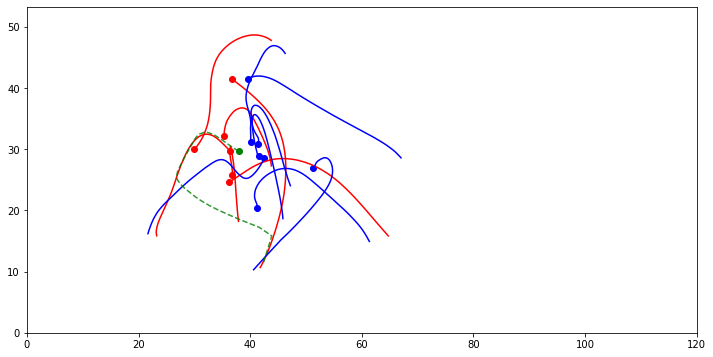

In [31]:
plot_play(2018090909,2430,df_week1)

dot's are starting positions.
Green line is a ball, red\blue are players from the opposite teams

For an another task submission, i've picked up an algorithm , which can predict defence pass interference

<a id="seven"></a>
# Defence Pass Interference

we need prepare the data first. DPI occures with at least 2 players , 

to predict that kind of penalty i want to transform every pair of players,

in the oppisite teams, into vectorized distance as a features.

i will also use distance to a ball .

**DPI PRIME EXAMPLE**

In [32]:
df_week16 = pd.read_csv(path/'week16.csv')

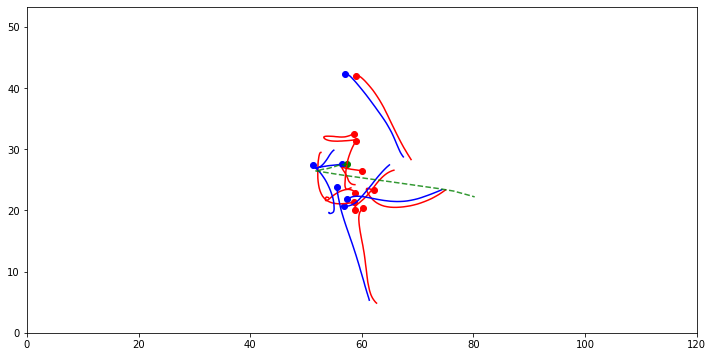

In [33]:
df_plays.iloc[19237].playDescription
plot_play(2018122201,1719,df_week16)

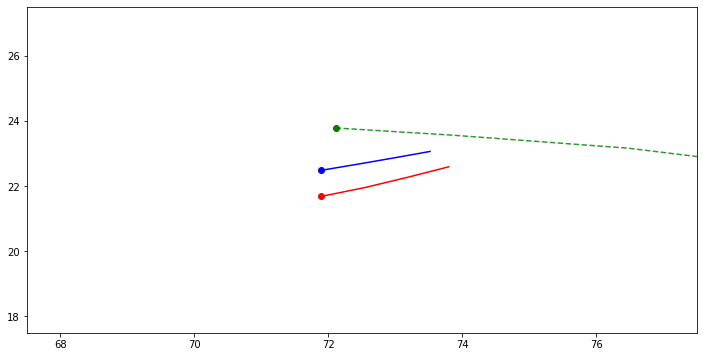

In [34]:
plt.figure(figsize=(12,6))
plt.xlim(67.5,77.5)
plt.ylim(17.5,27.5)
#
df1 = pd.DataFrame(df_week16[(df_week16.gameId == 2018122201) & (df_week16.playId == 1719) & (df_week16.displayName == 'Keenan Allen') & (df_week16.frameId > 35) & (df_week16.frameId < 40)]['x'])
df1['y'] = df_week16[(df_week16.gameId == 2018122201) & (df_week16.playId == 1719) & (df_week16.displayName == 'Keenan Allen') & (df_week16.frameId > 35) & (df_week16.frameId < 40)]['y']
df1.reset_index()
plt.scatter(df1.iloc[0]['x'],df1.iloc[0]['y'],c='b')
plt.plot('x','y',data=df1,c='b')
#
df2 = pd.DataFrame(df_week16[(df_week16.gameId == 2018122201) & (df_week16.playId == 1719) & (df_week16.displayName == 'Tony Jefferson') & (df_week16.frameId > 35) & (df_week16.frameId < 40)]['x'])
df2['y'] = df_week16[(df_week16.gameId == 2018122201) & (df_week16.playId == 1719) & (df_week16.displayName == 'Tony Jefferson') & (df_week16.frameId > 35) & (df_week16.frameId < 40)]['y']
df2.reset_index()
plt.scatter(df2.iloc[0]['x'],df2.iloc[0]['y'],c='r')
plt.plot('x','y',data=df2,c='r')
#
dfb = pd.DataFrame(df_week16[(df_week16.gameId == 2018122201) & (df_week16.playId == 1719) & (df_week16.displayName == 'Football') & (df_week16.frameId > 35) & (df_week16.frameId < 40)]['x'])
dfb['y'] = df_week16[(df_week16.gameId == 2018122201) & (df_week16.playId == 1719) & (df_week16.displayName == 'Football') & (df_week16.frameId > 35) & (df_week16.frameId < 40)]['y']
dfb.reset_index()
plt.scatter(dfb.iloc[0]['x'],dfb.iloc[0]['y'],c='g')
plt.plot('x','y',data=dfb,c='g',alpha=0.8,ls='dashed')

so this is how pre-DPI situation looks like.

pass receiver is slowing to catch a ball, tackler is moving at high speed towards him or with him.

ball is moving at high speed in close proximity.

that generally should be a sign for an algorithm that DPI could be there.

<a id="eight"></a>
# DATA PREPARATION

this is made for demonstration purpose , and i want to work with one week only due to computqation\time limits.

But that should be enough to get the idea

In [35]:
# getting full list of games and plays with DPI
df_week1_plays_ = pd.DataFrame(df_plays[df_plays.penaltyCodes == 'DPI'].groupby('gameId')['playId'].unique())

In [36]:
unique_games_week1 = df_week1.gameId.unique()

In [37]:
#i need a function to filter last names of players, don't see other way to get them in a case i query the data
def last_name_filter(desc):
    result = []
    result_2 = []
    str1 = str(desc)
    re1 = re.compile(r'([A-Z]([a-z]+)?\.[A-Z][a-z]+)')
    s1 = re1.findall(str1)
    for f in s1[1:]:
        str2 = str(f)
        re2 = re.compile(r'(\.[A-Z][a-z]+)')
        s2 = re2.findall(str2)
        result.append(s2[0])
    for d in result:
        re3 = re.compile(r'([A-Z][a-z]+)')
        str3 = str(d)
        s3 = re3.findall(str3)
        result_2.append(s3[0])
    return result_2

**creating dataframe for the DPI data**

In [38]:
df_dpi = pd.DataFrame(columns=['p1p2x','p1p2y','p1bx','p1by','p2bx','p2by','pl1speed','pl2speed','bspeed','dpi'])

* 'p1p2x' - distance between players by X
* 'p1p2y' - distance between players by y
* 'p1bx'  - distance between player 1 and a ball by X
* 'p1by'  - distance between player 1 and a ball by y
* 'p2bx'  - distance between player 2 and a ball by X
* 'p2by'  - distance between player 2 and a ball by y
* 'pl1speed' - speed of player1
* 'pl2speed' - speed of player2
* 'bspeed'   - speed of the ball
* 'dpi'      - dpi occurrence

In [39]:
#creating main function to query data with DPI
#finding 'pass outcome incomplete' frame id
#we need just last 3-5 frames before that (feel free to experiment with more\less frames tho)
def dpi_positive(game_id_dpi):
    global df_dpi
    try:
        play_dpi_id_list = df_week1_plays_.loc[game_id_dpi]['playId']
        for k in play_dpi_id_list:
            play_dpi_id = int(k)
            frameId_num = df_week1[(df_week1.gameId == game_id_dpi) & (df_week1.playId == play_dpi_id) & (df_week1.event == 'pass_outcome_incomplete')].frameId.mean()
            description = df_plays[(df_plays.gameId == game_id_dpi) & (df_plays.playId == play_dpi_id) & (df_plays.penaltyCodes == 'DPI')]['playDescription'].values
            lnf = last_name_filter(description)
            if len(lnf) < 2 or len(lnf) > 2:
                pass
            pl1x = df_week1[(df_week1.gameId == game_id_dpi) & (df_week1.playId == play_dpi_id) & (df_week1.displayName.str.endswith(lnf[0])) & (df_week1.frameId > (frameId_num-4)) & (df_week1.frameId < frameId_num)]['x'].mean()
            pl1y = df_week1[(df_week1.gameId == game_id_dpi) & (df_week1.playId == play_dpi_id) & (df_week1.displayName.str.endswith(lnf[0])) & (df_week1.frameId > (frameId_num-4)) & (df_week1.frameId < frameId_num)]['y'].mean()
            pl1speed = df_week1[(df_week1.gameId == game_id_dpi) & (df_week1.playId == play_dpi_id) & (df_week1.displayName.str.endswith(lnf[0])) & (df_week1.frameId > (frameId_num-4)) & (df_week1.frameId < frameId_num)]['s'].mean()
            pl2x = df_week1[(df_week1.gameId == game_id_dpi) & (df_week1.playId == play_dpi_id) & (df_week1.displayName.str.endswith(lnf[1])) & (df_week1.frameId > (frameId_num-4)) & (df_week1.frameId < frameId_num)]['x'].mean()
            pl2y = df_week1[(df_week1.gameId == game_id_dpi) & (df_week1.playId == play_dpi_id) & (df_week1.displayName.str.endswith(lnf[1])) & (df_week1.frameId > (frameId_num-4)) & (df_week1.frameId < frameId_num)]['y'].mean()
            pl2speed = df_week1[(df_week1.gameId == game_id_dpi) & (df_week1.playId == play_dpi_id) & (df_week1.displayName.str.endswith(lnf[1])) & (df_week1.frameId > (frameId_num-4)) & (df_week1.frameId < frameId_num)]['s'].mean()
            bx = df_week1[(df_week1.gameId == game_id_dpi) & (df_week1.playId == play_dpi_id) & (df_week1.displayName.str.endswith('Football')) & (df_week1.frameId > (frameId_num-4)) & (df_week1.frameId < frameId_num)]['x'].mean()
            by = df_week1[(df_week1.gameId == game_id_dpi) & (df_week1.playId == play_dpi_id) & (df_week1.displayName.str.endswith('Football')) & (df_week1.frameId > (frameId_num-4)) & (df_week1.frameId < frameId_num)]['y'].mean()
            bspeed = df_week1[(df_week1.gameId == game_id_dpi) & (df_week1.playId == play_dpi_id) & (df_week1.displayName.str.endswith('Football')) & (df_week1.frameId > (frameId_num-4)) & (df_week1.frameId < frameId_num)]['s'].mean()
            p1p2x = abs(pl1x - pl2x)
            p1p2y = abs(pl1y - pl2y)
            p1bx = abs(pl1x - bx)
            p1by = abs(pl1y - by)
            p2bx = abs(pl2x - bx)
            p2by = abs(pl2y - by)
            dpi = 1
            new_row = {'p1p2x':p1p2x,'p1p2y':p1p2y,'p1bx':p1bx,'p1by':p1by,'p2bx':p2bx,'p2by':p2by,'pl1speed':pl1speed,'pl2speed':pl2speed,'bspeed':bspeed,'dpi':dpi}
            df_dpi = df_dpi.append(new_row,ignore_index=True)
    except:
        pass

**FILLING DATAFRAME**

In [40]:
for game in unique_games_week1:
    dpi_positive(game)

In [41]:
df_dpi.drop(df_dpi.index[14:],inplace=True)

In [42]:
#that's our data with DPI
df_dpi.sample(5)

,p1p2x,p1p2y,p1bx,p1by,p2bx,p2by,pl1speed,pl2speed,bspeed,dpi
2,1.106667,0.040000,2.636667,2.390000,1.530000,2.350000,5.746667,6.186667,20.560000,1.0
12,0.833333,0.086667,1.866667,0.896667,2.700000,0.983333,5.456667,5.456667,8.316667,1.0
7,0.166667,1.323333,1.736667,2.596667,1.903333,3.920000,6.810000,5.410000,18.663333,1.0
8,0.953333,0.376667,1.176667,0.463333,2.130000,0.840000,8.473333,8.403333,15.710000,1.0
10,0.343333,0.416667,0.730000,1.693333,1.073333,2.110000,6.963333,7.596667,6.980000,1.0


for the sake of example i'm going to grab almost random values, but from the same games for a negative classification

In [43]:
df_dpi_NEG = pd.DataFrame(columns=['p1p2x','p1p2y','p1bx','p1by','p2bx','p2by','pl1speed','pl2speed','bspeed','dpi'])

In [44]:
def dpi_NEG(game_id_dpi):
    global df_dpi_NEG
    try:
        play_dpi_id_list = df_week1_plays_.loc[game_id_dpi]['playId']
        for k in play_dpi_id_list:
            play_dpi_id = int(k)
            min1 = df_week1[(df_week1.gameId == game_id_dpi) & (df_week1.playId == play_dpi_id)].frameId.min()
            max1 = df_week1[(df_week1.gameId == game_id_dpi) & (df_week1.playId == play_dpi_id)].frameId.max()
            frameId_num = (min1 + max1)/2
            lnf = []
            lnf.append(df_week1[(df_week1.gameId == game_id_dpi) & (df_week1.playId == play_dpi_id) & (df_week1.team == 'home')]['displayName'].head(1).item())
            lnf.append(df_week1[(df_week1.gameId == game_id_dpi) & (df_week1.playId == play_dpi_id) & (df_week1.team == 'away')]['displayName'].head(1).item())
            if len(lnf) < 2 or len(lnf) > 2:
                pass
            pl1x = df_week1[(df_week1.gameId == game_id_dpi) & (df_week1.playId == play_dpi_id) & (df_week1.displayName.str.endswith(lnf[0])) & (df_week1.frameId > (frameId_num-4)) & (df_week1.frameId < frameId_num)]['x'].mean()
            pl1y = df_week1[(df_week1.gameId == game_id_dpi) & (df_week1.playId == play_dpi_id) & (df_week1.displayName.str.endswith(lnf[0])) & (df_week1.frameId > (frameId_num-4)) & (df_week1.frameId < frameId_num)]['y'].mean()
            pl1speed = df_week1[(df_week1.gameId == game_id_dpi) & (df_week1.playId == play_dpi_id) & (df_week1.displayName.str.endswith(lnf[0])) & (df_week1.frameId > (frameId_num-4)) & (df_week1.frameId < frameId_num)]['s'].mean()
            pl2x = df_week1[(df_week1.gameId == game_id_dpi) & (df_week1.playId == play_dpi_id) & (df_week1.displayName.str.endswith(lnf[1])) & (df_week1.frameId > (frameId_num-4)) & (df_week1.frameId < frameId_num)]['x'].mean()
            pl2y = df_week1[(df_week1.gameId == game_id_dpi) & (df_week1.playId == play_dpi_id) & (df_week1.displayName.str.endswith(lnf[1])) & (df_week1.frameId > (frameId_num-4)) & (df_week1.frameId < frameId_num)]['y'].mean()
            pl2speed = df_week1[(df_week1.gameId == game_id_dpi) & (df_week1.playId == play_dpi_id) & (df_week1.displayName.str.endswith(lnf[1])) & (df_week1.frameId > (frameId_num-4)) & (df_week1.frameId < frameId_num)]['s'].mean()
            bx = df_week1[(df_week1.gameId == game_id_dpi) & (df_week1.playId == play_dpi_id) & (df_week1.displayName.str.endswith('Football')) & (df_week1.frameId > (frameId_num-4)) & (df_week1.frameId < frameId_num)]['x'].mean()
            by = df_week1[(df_week1.gameId == game_id_dpi) & (df_week1.playId == play_dpi_id) & (df_week1.displayName.str.endswith('Football')) & (df_week1.frameId > (frameId_num-4)) & (df_week1.frameId < frameId_num)]['y'].mean()
            bspeed = df_week1[(df_week1.gameId == game_id_dpi) & (df_week1.playId == play_dpi_id) & (df_week1.displayName.str.endswith('Football')) & (df_week1.frameId > (frameId_num-4)) & (df_week1.frameId < frameId_num)]['s'].mean()
            p1p2x = abs(pl1x - pl2x)
            p1p2y = abs(pl1y - pl2y)
            p1bx = abs(pl1x - bx)
            p1by = abs(pl1y - by)
            p2bx = abs(pl2x - bx)
            p2by = abs(pl2y - by)
            dpi = 0
            new_row = {'p1p2x':p1p2x,'p1p2y':p1p2y,'p1bx':p1bx,'p1by':p1by,'p2bx':p2bx,'p2by':p2by,'pl1speed':pl1speed,'pl2speed':pl2speed,'bspeed':bspeed,'dpi':dpi}
            df_dpi_NEG = df_dpi_NEG.append(new_row,ignore_index=True)
    except:
        pass

In [45]:
for game in unique_games_week1:
    dpi_NEG(game)

In [46]:
df_dpi_NEG.sample(5)

,p1p2x,p1p2y,p1bx,p1by,p2bx,p2by,pl1speed,pl2speed,bspeed,dpi
11,1.313333,1.8400,9.110000,12.296667,7.796667,14.136667,3.773333,5.653333,1.286667,0.0
2,17.615000,7.2650,0.065000,0.487500,17.680000,7.752500,2.835000,2.645000,3.560000,0.0
4,22.107500,8.9925,0.452500,0.287500,22.560000,8.705000,0.855000,2.750000,0.590000,0.0
10,0.976667,2.0400,13.983333,5.420000,14.960000,7.460000,5.786667,3.300000,0.796667,0.0
3,23.753333,6.7100,0.170000,0.446667,23.583333,6.263333,2.740000,2.753333,1.590000,0.0


In [47]:
frames = [df_dpi,df_dpi_NEG]
df = pd.concat(frames)

<a id="nine"></a>
# Model creation

**Feature scaling**

In [48]:
scaler = StandardScaler()
df[['p1p2x','p1p2y','p1bx','p1by','p2bx','p2by','pl1speed','pl2speed','bspeed']] = scaler.fit_transform(df[['p1p2x','p1p2y','p1bx','p1by','p2bx','p2by','pl1speed','pl2speed','bspeed']])

In [49]:
df.sample(5)

,p1p2x,p1p2y,p1bx,p1by,p2bx,p2by,pl1speed,pl2speed,bspeed,dpi
13,1.417974,1.247679,1.862335,-0.608464,-0.121233,1.605435,-1.422578,-0.453554,-0.172773,0.0
1,0.045124,2.175909,1.827493,0.089238,1.230452,2.398123,-1.762362,1.068817,-0.653976,0.0
9,-0.621353,2.040816,0.662086,3.019804,0.520793,0.237938,0.457225,0.088256,-0.851365,0.0
2,-0.688940,-0.759798,-0.491707,-0.276543,-0.782788,-0.530025,0.481727,0.492907,2.176504,1.0
3,2.499827,0.095648,-0.788065,-0.779493,2.368287,0.152996,-0.818317,-1.068109,-0.827087,0.0


train\test sets. 

i want to avoid cross validation this time, because ,once again, it's just demonstration.

since i carelessly picked up data , no reason to test model multiple times

In [50]:
df.reset_index(inplace=True)
X = df.drop(['dpi'],axis=1)
y = df['dpi']

In [51]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.4,random_state=5)

<a id="ten"></a>
# model score

In [52]:
model = LinearSVC()
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.9166666666666666

<a id="eleven"></a>
# conclusion

With the last 3 frames per player\ball we can determine with decent success (0.916 score) is there any DPI threat, before ball lands or DPI happends.

Due to time\cumputation limits i was carelessly pickig data. But with real task you should consider going though all played weeks and all players. 

And since this is basically binary classification, with more unbalanced data i would recommend to calculate F1 score, and confusion matrix.

On top of that i recommend try different kernel types and models, and maybe add\throw away some features and frames.

There is a plenty ways for the experiment. 
